<a href="https://colab.research.google.com/github/yuancx2025/526_project_group2/blob/main/Data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Input the ticket level data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 666.4/666.4 kB 10.8 MB/s eta 0:00:00


In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/yuancx2025/526_project_group2/main/KG_cost_small.csv"
data = pd.read_csv(url)

data.info()      # check structure
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222252 entries, 0 to 222251
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   origin        222252 non-null  object 
 1   dest          222252 non-null  object 
 2   year          222252 non-null  int64  
 3   HHI_route     222252 non-null  float64
 4   gini_airline  222252 non-null  float64
 5   meanfare      222252 non-null  float64
 6   maxfare       222252 non-null  float64
 7   minfare       222252 non-null  float64
 8   gini          222252 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 15.3+ MB


,origin,dest,year,HHI_route,gini_airline,meanfare,maxfare,minfare,gini
0,ANC,FAI,2002,0.998700,0.033060,133.250000,144.5,122.0,0.042214
1,ANC,FAI,2002,0.994030,0.017388,136.812500,165.5,122.0,0.034776
2,ANC,FAI,2003,0.998211,0.062617,133.750000,150.5,117.0,0.062617
3,ANC,FAI,2002,0.994769,0.033655,130.916672,151.5,120.0,0.053363
4,ANC,FAI,2005,0.997391,0.021482,155.166672,163.0,148.0,0.021482


Input graph level data (help visualize)

In [2]:
import pandas as pd

airports_raw = pd.read_csv(
    "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
    header=None
)


airports = airports_raw[[1, 2, 3, 4, 5, 6, 7, 8, 9]]
airports.columns = ["airport_name", "city", "country", "IATA", "ICAO", "lat", "lon", "alt", "timezone"]


airports = airports[airports["IATA"].notna()]
airports.head()

,airport_name,city,country,IATA,ICAO,lat,lon,alt,timezone
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10


Combine tow data.

In [3]:

data = data.merge(
    airports[["IATA", "lat", "lon", "country", "city"]],
    how="left",
    left_on="origin",
    right_on="IATA"
).rename(columns={
    "lat": "origin_lat",
    "lon": "origin_lon",
    "country": "origin_country",
    "city": "origin_city"
})

In [4]:
# Merge destination coordinates
data = data.merge(
    airports[["IATA", "lat", "lon", "country", "city"]],
    how="left",
    left_on="dest",
    right_on="IATA"
).rename(columns={
    "lat": "dest_lat",
    "lon": "dest_lon",
    "country": "dest_country",
    "city": "dest_city"
})

Check merge level and shrink into US ariline market

In [5]:
data[["origin", "origin_lat", "origin_lon", "dest", "dest_lat", "dest_lon"]].head()
data["origin_lat"].notna().mean(), data["dest_lat"].notna().mean()
data_us = data[(data["origin_country"]=="United States") &
               (data["dest_country"]=="United States")]

In [6]:
routes_2005 = (data_us[data_us["year"]==2005]
               .groupby(["origin","dest"], as_index=False)
               .agg({"origin_lat":"first","origin_lon":"first",
                     "dest_lat":"first","dest_lon":"first",
                     "HHI_route":"mean"}))
routes_2005["market_type"] = pd.cut(
    routes_2005["HHI_route"],
    bins=[-float("inf"), 0.2, 0.6, float("inf")],
    labels=["competitive", "oligopoly", "monopoly"]
)

Graph the

/tmp/ipython-input-1096684822.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=routes_2005,


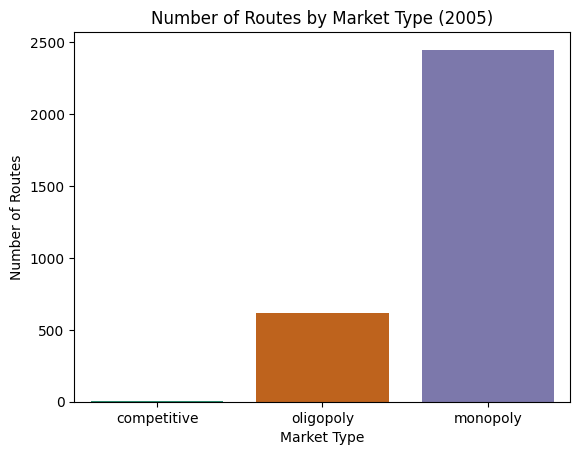

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=routes_2005,
              x="market_type",
              order=["competitive","oligopoly","monopoly"],
              palette={"competitive":"#1b9e77",
                       "oligopoly":"#d95f02",
                       "monopoly":"#7570b3"})
plt.title("Number of Routes by Market Type (2005)")
plt.xlabel("Market Type")
plt.ylabel("Number of Routes")
plt.show()

In [9]:
!pip install geodatasets --quiet

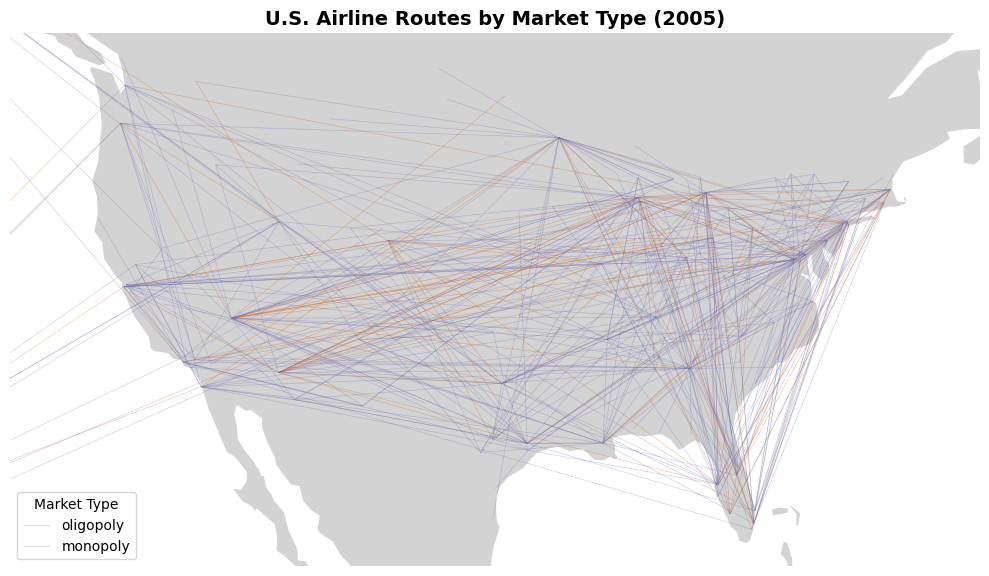

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geodatasets

# --- US basemap ---
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
usa = world.cx[-130:-65, 24:50]

# --- choose a small sample to reduce clutter ---
routes_sample = routes_2005.sample(frac=0.15, random_state=42)

# --- (re‑)build geometry safely ---
from shapely.geometry import LineString
routes_sample = routes_sample.dropna(subset=["origin_lon","origin_lat","dest_lon","dest_lat"])
routes_sample["geometry"] = [
    LineString([(r.origin_lon, r.origin_lat), (r.dest_lon, r.dest_lat)])
    for _, r in routes_sample.iterrows()
]
routes_gdf = gpd.GeoDataFrame(routes_sample, geometry="geometry", crs="EPSG:4326")

color_map = {
    "competitive": "#1b9e77",
    "oligopoly": "#d95f02",
    "monopoly": "#7570b3"
}

fig, ax = plt.subplots(figsize=(10, 6))
usa.plot(ax=ax, color="lightgray", edgecolor="white")

# --- plot each market type if it exists ---
for label, color in color_map.items():
    subset = routes_gdf[routes_gdf["market_type"] == label]
    if len(subset) > 0 and subset.geometry.notna().any():
        subset = subset[subset.geometry.is_valid]
        subset.plot(ax=ax, color=color, linewidth=0.4,
                    alpha=0.4, label=label)

# --- decorations ---
plt.legend(title="Market Type", loc="lower left", frameon=True)
plt.title("U.S. Airline Routes by Market Type (2005)", fontsize=14, weight="bold")
plt.xlim(-130, -65)
plt.ylim(24, 50)
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd


data["route"] = data["origin"].astype(str) + "_" + data["dest"].astype(str)
df = data.copy()
# check variable
df[['route','year','HHI_route','meanfare','maxfare','minfare','gini','gini_airline']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222252 entries, 0 to 222251
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   route         222252 non-null  object 
 1   year          222252 non-null  int64  
 2   HHI_route     222252 non-null  float64
 3   meanfare      222252 non-null  float64
 4   maxfare       222252 non-null  float64
 5   minfare       222252 non-null  float64
 6   gini          222252 non-null  float64
 7   gini_airline  222252 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 13.6+ MB


In [14]:
!pip install linearmodels --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00


In [15]:
from linearmodels import PanelOLS
import statsmodels.api as sm


df = df.set_index(['route','year'])
# regression 1 ： mean fare
mod_mean = PanelOLS.from_formula(
    'meanfare ~ HHI_route + EntityEffects + TimeEffects',
    data=df).fit(cov_type='clustered', cluster_entity=True)

# regression 2 ： min fare
mod_min = PanelOLS.from_formula(
    'minfare ~ HHI_route + EntityEffects + TimeEffects',
    data=df).fit(cov_type='clustered', cluster_entity=True)

# regression 3 ： gini
mod_gini = PanelOLS.from_formula(
    'gini ~ HHI_route + EntityEffects + TimeEffects',
    data=df).fit(cov_type='clustered', cluster_entity=True)

print(mod_mean.summary)
print(mod_min.summary)
print(mod_gini.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               meanfare   R-squared:                        0.0430
Estimator:                   PanelOLS   R-squared (Between):              0.4686
No. Observations:              222252   R-squared (Within):               0.0432
Date:                Sun, Oct 19 2025   R-squared (Overall):              0.4014
Time:                        19:27:05   Log-likelihood                -1.107e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9755.8
Entities:                        5113   P-value                           0.0000
Avg Obs:                       43.468   Distribution:                F(1,217125)
Min Obs:                       1.0000                                           
Max Obs:                       382.00   F-statistic (robust):             721.64
                            